In [27]:
import os
import pickle
import random
import fnmatch
import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
from imgaug import augmenters as img_aug

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3269154110633657323
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10540023808
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15331975229510042123
physical_device_desc: "device: 0, name: GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



2022-10-23 13:27:21.038855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 13:27:21.039132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 13:27:21.039315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 13:27:21.039550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 13:27:21.039737: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [28]:
np.set_printoptions(formatter={"float_kind": lambda x: "%.4f" % x})

pd.set_option("display.width", 300)
pd.set_option("display.float_format", "{:,.4f}".format)
pd.set_option("display.max_colwidth", 200)


## Load Train Data


In [32]:
image_paths = []
# lab_dirs = list(Path("train_data_generation/data/drive_with_keypress/").glob("*"))
# for lab_dir in lab_dirs:
#     frame_paths = list(lab_dir.glob("*.png"))
#     for frame_path in frame_paths:
#         image_paths.append(frame_path)
image_paths = list(Path("train_data_generation/data/drive_with_keypress/28/").glob("*.png"))
image_paths.sort()


In [33]:
print(len(image_paths))

994


In [34]:
steering_angles = []
for image_path in image_paths:
    steering_angles.append(int(float(image_path.stem[13:]) + 0.5))


image_path: train_data_generation/data/drive_with_keypress/28/frame_000410_77.png
steering_Angle: 77


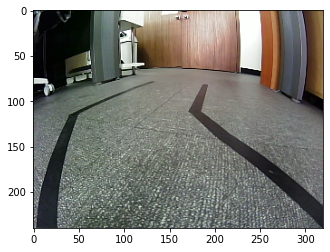

In [36]:
image_index = random.randint(0, len(image_paths))
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index])
print("steering_Angle: %d" % steering_angles[image_index])
df = pd.DataFrame()
df["ImagePath"] = image_paths
df["Angle"] = steering_angles


(array([56.0000, 0.0000, 0.0000, 20.0000, 79.0000, 57.0000, 50.0000,
        38.0000, 76.0000, 17.0000, 25.0000, 27.0000, 120.0000, 58.0000,
        41.0000, 13.0000, 51.0000, 20.0000, 17.0000, 26.0000, 59.0000,
        38.0000, 48.0000, 38.0000, 20.0000]),
 array([48.0000, 51.2800, 54.5600, 57.8400, 61.1200, 64.4000, 67.6800,
        70.9600, 74.2400, 77.5200, 80.8000, 84.0800, 87.3600, 90.6400,
        93.9200, 97.2000, 100.4800, 103.7600, 107.0400, 110.3200, 113.6000,
        116.8800, 120.1600, 123.4400, 126.7200, 130.0000]),
 <BarContainer object of 25 artists>)

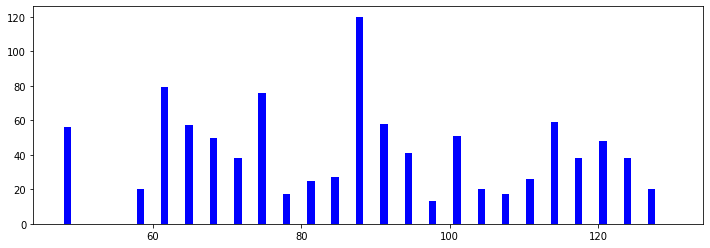

In [37]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df["Angle"], num_of_bins)

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.hist(df["Angle"], bins=num_of_bins, width=1, color="blue")


Training data: 894
Validation data: 100


Text(0.5, 1.0, 'Validation Data')

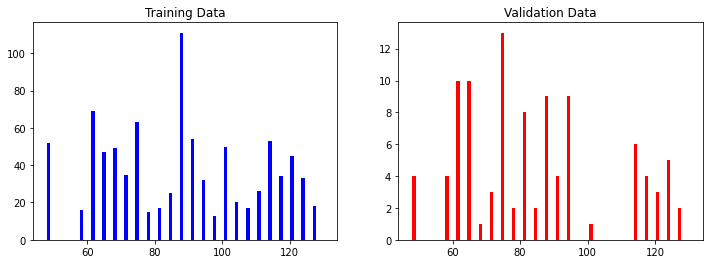

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(
    image_paths, steering_angles, test_size=0.1
)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color="blue")
axes[0].set_title("Training Data")
axes[1].hist(y_valid, bins=num_of_bins, width=1, color="red")
axes[1].set_title("Validation Data")


## Image Augumentation

Since we only have a few hundred images, to train a deep network, we need a lot more images. Instead of running our car, let's try to augment our data. There are a couple of ways to do that.

1. Zoom: crop out a smaller image from the center
1. Pan: crop out a smaller image from left or right side
1. adjust brightness of the image
1. flip the image horizontally, i.e do a left to right flip, and change the steering angle coorespondingly
1. introduce an Gaussian blur

We can combine the above augmentation techniques to generate 100s times of the training images, with just a few hundred real images.


Text(0.5, 1.0, 'zoomed')

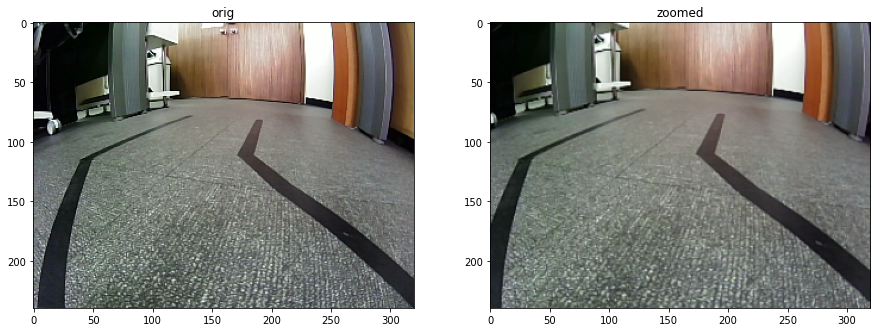

In [40]:
def my_imread(image_path):
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image


fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")


Text(0.5, 1.0, 'panned')

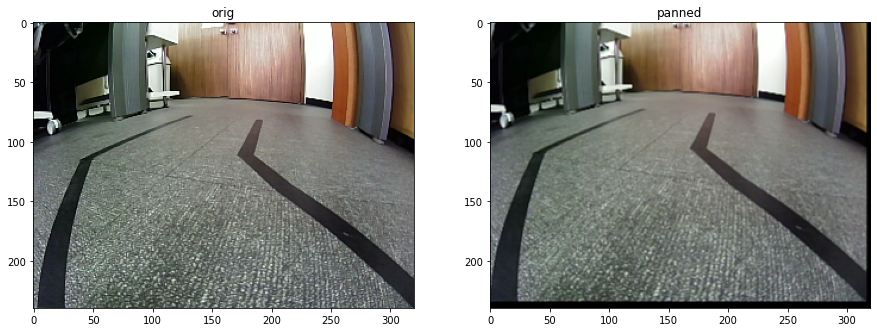

In [41]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")


Text(0.5, 1.0, 'brightness adjusted')

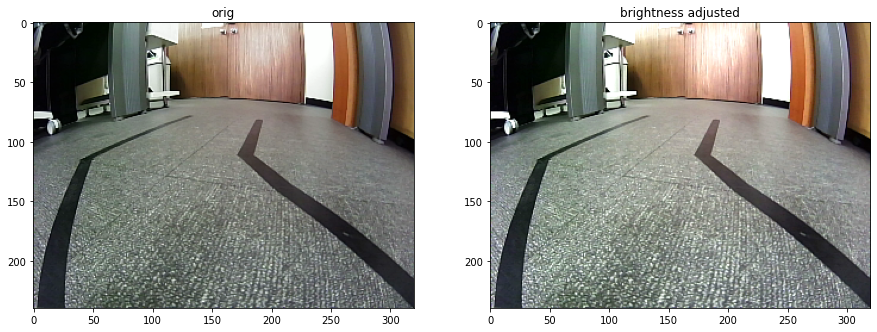

In [42]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image


fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")


Text(0.5, 1.0, 'blurred')

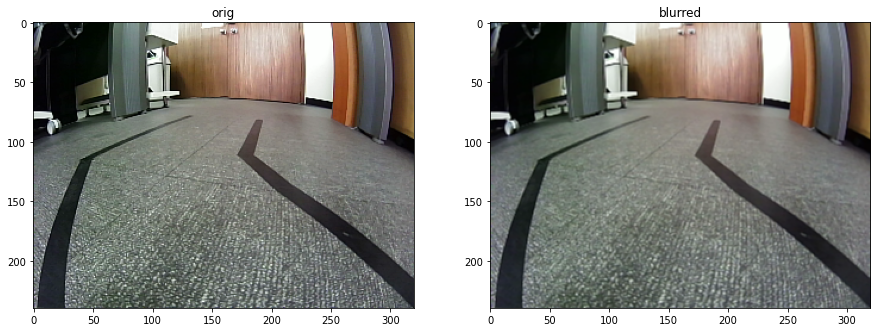

In [43]:
def blur(image):
    kernel_size = random.randint(
        1, 5
    )  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image, (kernel_size, kernel_size))

    return image


fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")


Text(0.5, 1.0, 'flipped, angle=77')

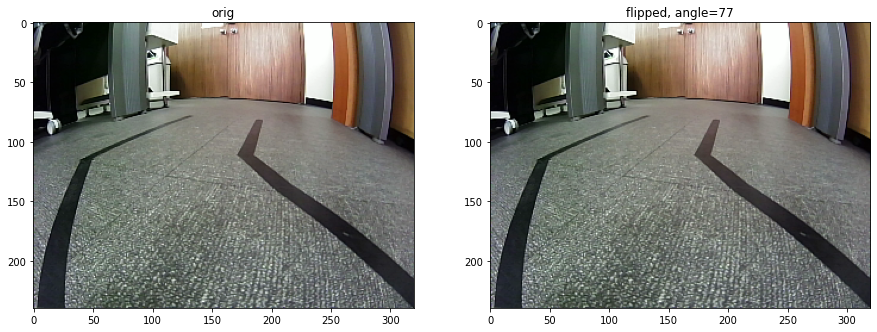

In [44]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image, 1)
        steering_angle = 180 - steering_angle

    return image, steering_angle


fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)


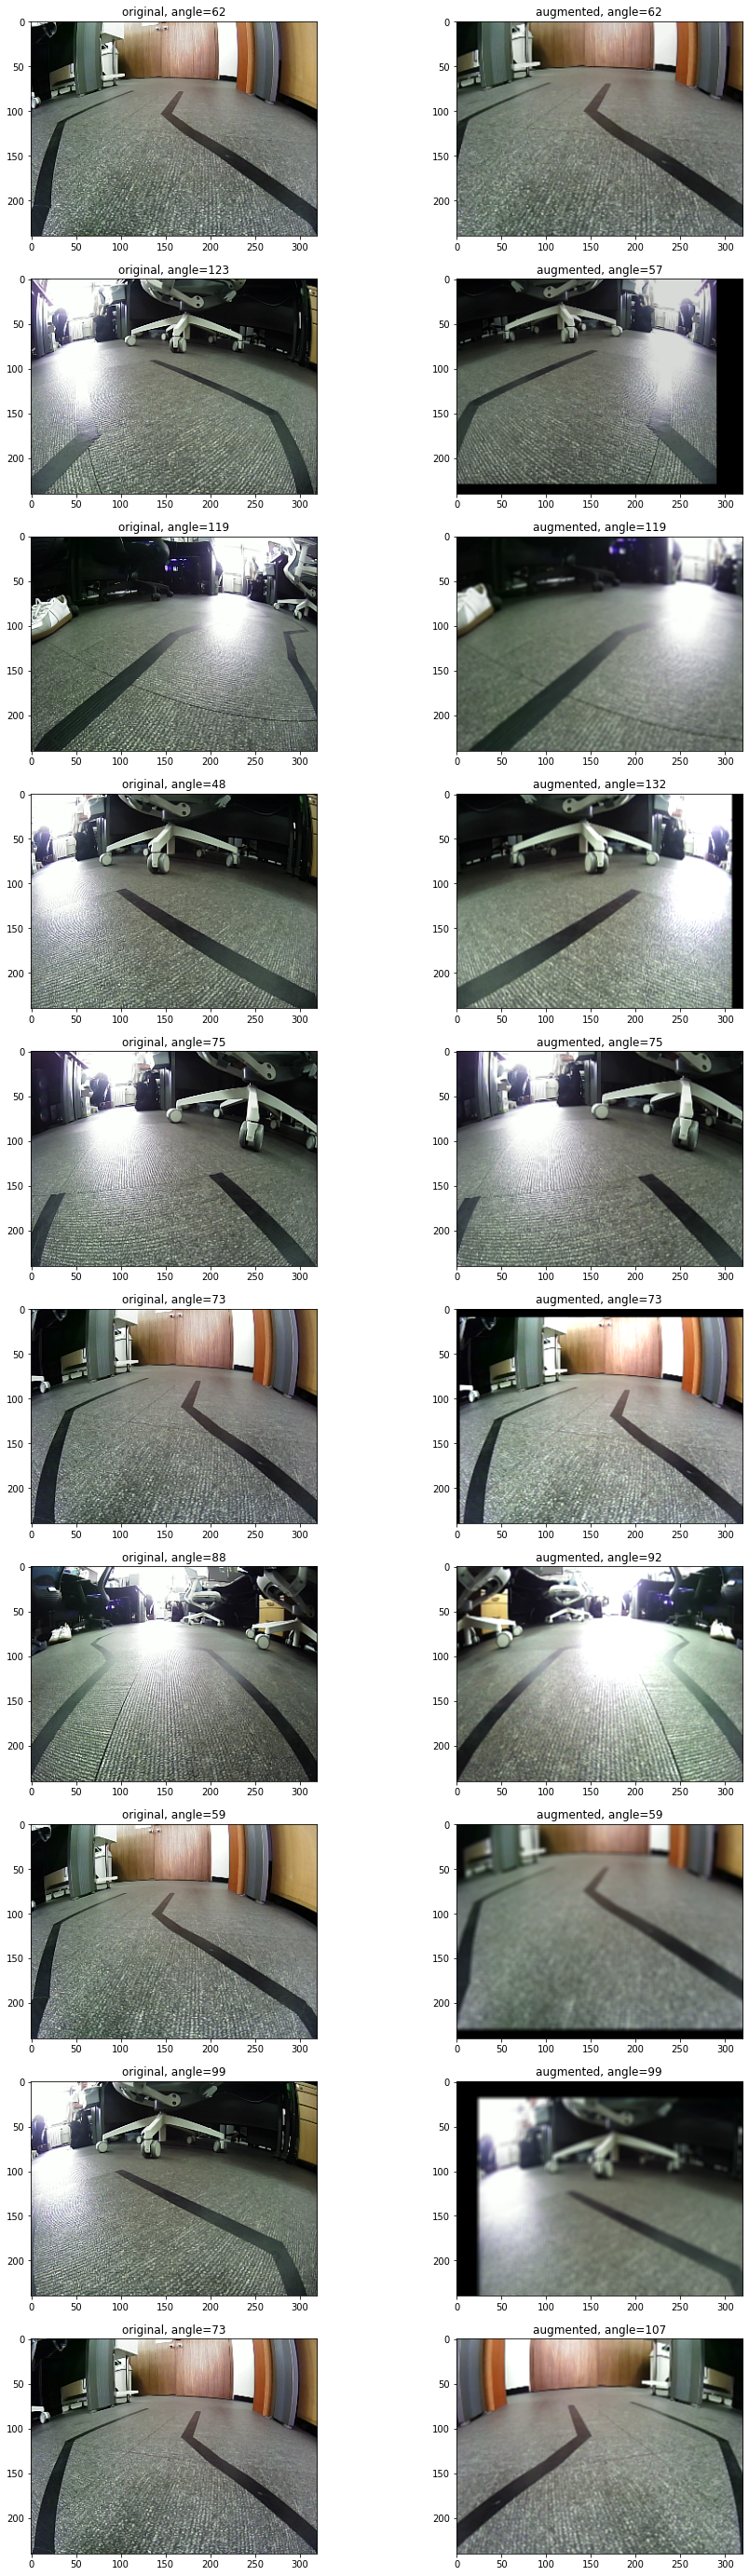

In [45]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)

    return image, steering_angle


# show a few randomly augmented images?
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[rand_index]
    steering_angle_orig = steering_angles[rand_index]

    image_orig = my_imread(image_path)
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)

    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)


## Preprocess Training Data for Nvidia Model


Text(0.5, 1.0, 'processed')

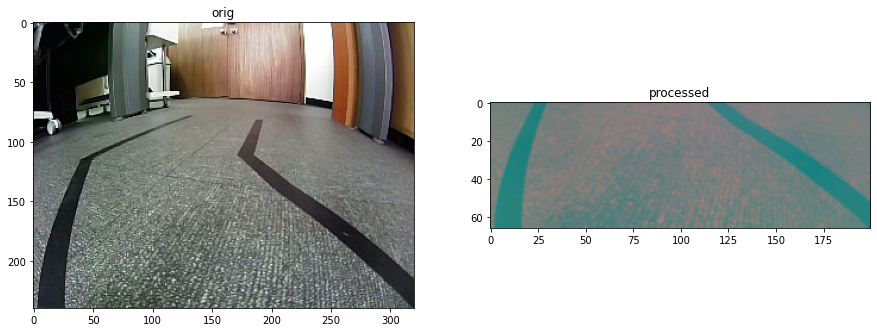

In [46]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[
        int(height / 2) :, :, :
    ]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(
        image, cv2.COLOR_RGB2YUV
    )  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3, 3), 0)
    image = cv2.resize(image, (200, 66))  # input image size (200,66) Nvidia model
    # image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    image = image.astype(np.uint8)
    return image


fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")


In [47]:
def nvidia_model():
    model = Sequential(name="Nvidia_Model")

    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data

    # Convolution Layers
    model.add(
        Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation="elu")
    )
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation="elu"))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation="elu"))
    model.add(Conv2D(64, (3, 3), activation="elu"))
    model.add(Dropout(0.2))  # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation="elu"))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2))  # not in original model. added for more robustness
    model.add(Dense(100, activation="elu"))
    model.add(Dense(50, activation="elu"))
    model.add(Dense(10, activation="elu"))

    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1))

    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(learning_rate=1e-3)  # lr is learning rate
    model.compile(loss="mse", optimizer=optimizer)

    return model


In [48]:
model = nvidia_model()
print(model.summary())
# check at we will have 252,219 trainable parameters


Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_7 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 dropout_2 (Dropout)         (None, 3, 20, 64)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

In [49]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        batch_images = []
        batch_steering_angles = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)

            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)

        yield (np.asarray(batch_images), np.asarray(batch_steering_angles))


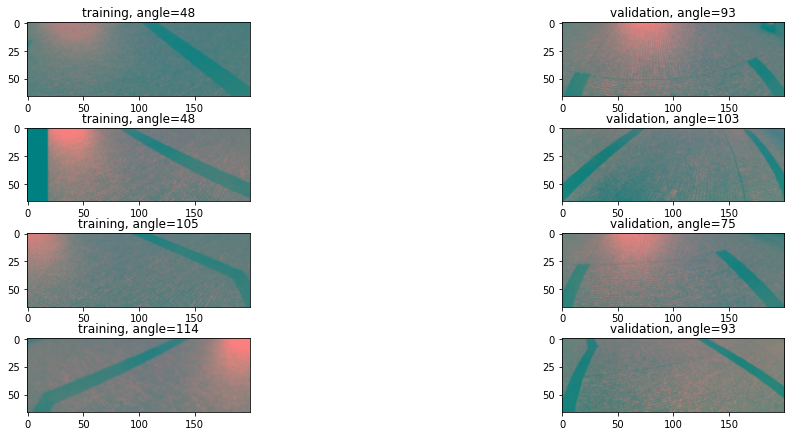

In [50]:
ncol = 2
batch_size = 4

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, batch_size, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, batch_size, False))

fig, axes = plt.subplots(batch_size, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(batch_size):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])


In [51]:
# clean up log folder for tensorboard
model_output_dir = Path("lane_navigation/model/")
log_dir_root = f"{model_output_dir}/logs/"
#!rm -rf $log_dir_root


In [52]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_output_dir, "lane_navigation_check.h5"),
    verbose=1,
    save_best_only=True,
)

history = model.fit_generator(
    image_data_generator(X_train, y_train, batch_size=100, is_training=True),
    steps_per_epoch=300,
    epochs=20,
    validation_data=image_data_generator(
        X_valid, y_valid, batch_size=100, is_training=False
    ),
    validation_steps=200,
    verbose=1,
    shuffle=1,
    callbacks=[checkpoint_callback],
)
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir, "lane_navigation_final.h5"))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir, "history.pickle")
with open(history_path, "wb") as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)


Epoch 1/20
300/300 [==============================] - ETA: 0s - loss: 376.5102
Epoch 00001: val_loss improved from inf to 56.41981, saving model to lane_navigation/model/lane_navigation_check.h5
300/300 [==============================] - 102s 340ms/step - loss: 376.5102 - val_loss: 56.4198
Epoch 2/20
300/300 [==============================] - ETA: 0s - loss: 125.2204
Epoch 00002: val_loss improved from 56.41981 to 44.10355, saving model to lane_navigation/model/lane_navigation_check.h5
300/300 [==============================] - 99s 332ms/step - loss: 125.2204 - val_loss: 44.1035
Epoch 3/20
300/300 [==============================] - ETA: 0s - loss: 89.1756
Epoch 00003: val_loss improved from 44.10355 to 25.90371, saving model to lane_navigation/model/lane_navigation_check.h5
300/300 [==============================] - 99s 332ms/step - loss: 89.1756 - val_loss: 25.9037
Epoch 4/20
300/300 [==============================] - ETA: 0s - loss: 66.5209
Epoch 00004: val_loss improved from 25.9037

In [53]:
# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(model_output_dir, "history.pickle")
with open(history_path, "rb") as f:
    history = pickle.load(f)


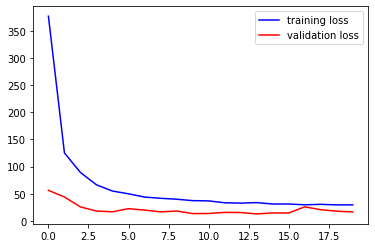

In [54]:
history
plt.plot(history["loss"], color="blue")
plt.plot(history["val_loss"], color="red")
plt.legend(["training loss", "validation loss"])


In [55]:
from sklearn.metrics import mean_squared_error, r2_score


def summarize_prediction(Y_true, Y_pred):

    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)

    print(f"mse       = {mse:.2}")
    print(f"r_squared = {r_squared:.2%}")
    print()


def predict_and_summarize(X, Y):
    model = load_model(f"{model_output_dir}/lane_navigation_check.h5")
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred


mse       = 1.6e+01
r_squared = 96.74%



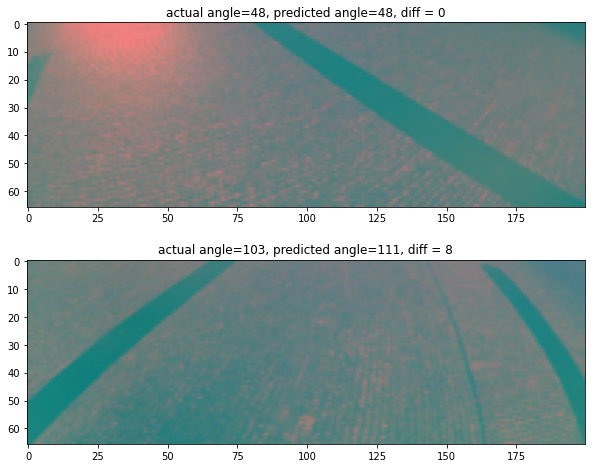

In [56]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(
        f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}"
    )
